In [1]:
import torch
import torchvision
import numpy as np
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = torchvision.datasets.MNIST(root=ROOT, train=True, download=True)

C:\Users\Tyrone\anaconda3\envs\nlp\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
mean = train_data.data.float().mean() / 225
std = train_data.data.float().std() / 225

print(f'data mean: {mean}')
print(f'data std: {std}')

data mean: 0.14808188378810883
data std: 0.34918883442878723


In [5]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0, )),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [6]:
train_data = torchvision.datasets.MNIST(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.MNIST(root=ROOT,
                                       train=False,
                                       download=True,
                                       transform=test_transforms)

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [8]:
import matplotlib.pyplot as plt

def plot_images(images):
    n_images = len(images)
    rows = cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

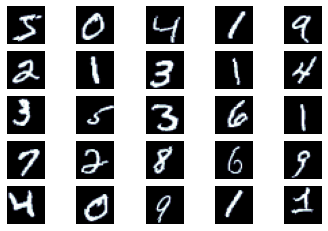

In [9]:
N_IMAGES = 25

# images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
images = [train_data[i][0] for i in range(N_IMAGES)]

plot_images(images)

In [10]:
VALID_RATIO = 0.1

n_train_examples = int(len(train_data) * (1 - VALID_RATIO))
n_test_examples = int(len(train_data) * VALID_RATIO)

In [11]:
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_test_examples])

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [13]:
import copy

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_iterator = DataLoader(train_data, BATCH_SIZE, True)
valid_iterator = DataLoader(valid_data, BATCH_SIZE, False)
test_iterator = DataLoader(test_data, BATCH_SIZE, False)

In [15]:
from torch import nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 16,
                               kernel_size = 5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
    
    def forward(self, batch):
        batch = self.conv1(batch)
        batch = F.max_pool2d(batch, kernel_size=2)
        batch = self.relu(batch)
        
        batch = self.conv2(batch)
        batch = F.max_pool2d(batch, kernel_size=2)
        batch = self.relu(batch)
        
        batch = batch.view(batch.shape[0], -1)
        
        h = batch

        batch = self.relu(self.fc_1(batch))
        batch = self.relu(self.fc_2(batch))
        
        preds = self.fc_3(batch)

        return preds, h

In [16]:
model = LeNet()

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

44426

In [18]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [20]:
def calculate_accuracy(preds, labels):
    top_preds = torch.argmax(preds, dim=1, keepdim=True)
    correct = top_preds.eq(labels.view_as(top_preds)).sum()
    acc = correct.float() / labels.shape[0]

    return acc

In [21]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for images, labels in iterator:
        images, labels = images.to(device), labels.to(device)

        preds, _ = model(images)

        loss = criterion(preds, labels)
        acc = calculate_accuracy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for images, labels in iterator:
            images, labels = images.to(device), labels.to(device)

            preds, _ = model(images)

            loss = criterion(preds, labels)
            acc = calculate_accuracy(preds, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [23]:
N_EPOCH = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, train_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNet-model')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

C:\Users\Tyrone\anaconda3\envs\nlp\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01
	Train Loss: 0.785 | Train Acc: 75.23%
	 Val. Loss: 0.320 |  Val. Acc: 90.32%
Epoch: 02
	Train Loss: 0.238 | Train Acc: 92.73%
	 Val. Loss: 0.191 |  Val. Acc: 94.13%
Epoch: 03
	Train Loss: 0.163 | Train Acc: 95.06%
	 Val. Loss: 0.135 |  Val. Acc: 95.94%
Epoch: 04
	Train Loss: 0.131 | Train Acc: 95.98%
	 Val. Loss: 0.105 |  Val. Acc: 96.73%
Epoch: 05
	Train Loss: 0.109 | Train Acc: 96.61%
	 Val. Loss: 0.099 |  Val. Acc: 96.81%
Epoch: 06
	Train Loss: 0.090 | Train Acc: 97.19%
	 Val. Loss: 0.081 |  Val. Acc: 97.51%
Epoch: 07
	Train Loss: 0.083 | Train Acc: 97.39%
	 Val. Loss: 0.081 |  Val. Acc: 97.39%
Epoch: 08
	Train Loss: 0.074 | Train Acc: 97.65%
	 Val. Loss: 0.073 |  Val. Acc: 97.68%
Epoch: 09
	Train Loss: 0.070 | Train Acc: 97.76%
	 Val. Loss: 0.068 |  Val. Acc: 97.95%
Epoch: 10
	Train Loss: 0.063 | Train Acc: 98.03%
	 Val. Loss: 0.057 |  Val. Acc: 98.26%


In [24]:
model.load_state_dict(torch.load('LeNet-model'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

	 Test Loss: 0.036 |  Test Acc: 98.86%


In [25]:

def get_prediction(model, iterator, device):
    model.eval()

    images, labels, preds = [], [], []

    with torch.no_grad():
        for image, label in iterator:
            image = image.to(device)
            
            pred, _ = model(image)
            pred = F.softmax(pred, dim=-1)
            # pred = torch.argmax(pred, dim=-1)

            images.append(image.cpu())
            labels.append(label)
            preds.append(pred.cpu())
    
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    preds = torch.cat(preds, dim=0)

    return images, labels, preds

In [26]:
from sklearn import metrics

def plot_confusion_matrix(labels, preds):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, preds)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10))
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

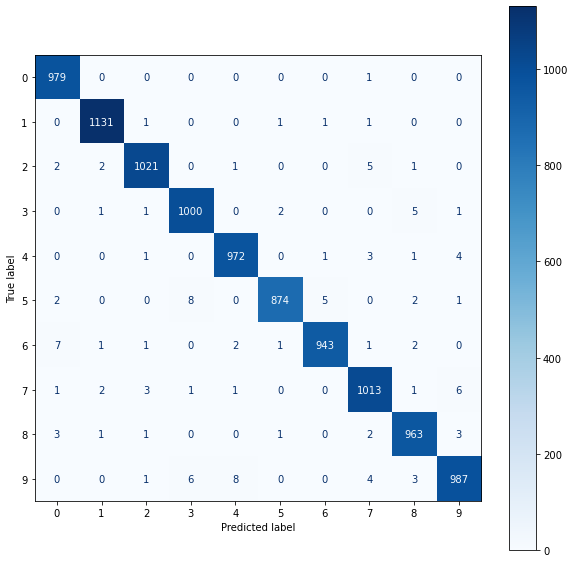

In [27]:
images, labels, preds = get_prediction(model, test_iterator, device)

plot_confusion_matrix(labels, torch.argmax(preds, dim=1))

In [28]:
def plot_most_incorrect(incorrect_examples, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect_examples[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

In [29]:
corrects = torch.eq(labels, torch.argmax(preds, dim=1))

incorrect_examples = []
for image, label, pred, correct in zip(images, labels, preds, corrects):
    if not correct:
        incorrect_examples.append((image, label, pred))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

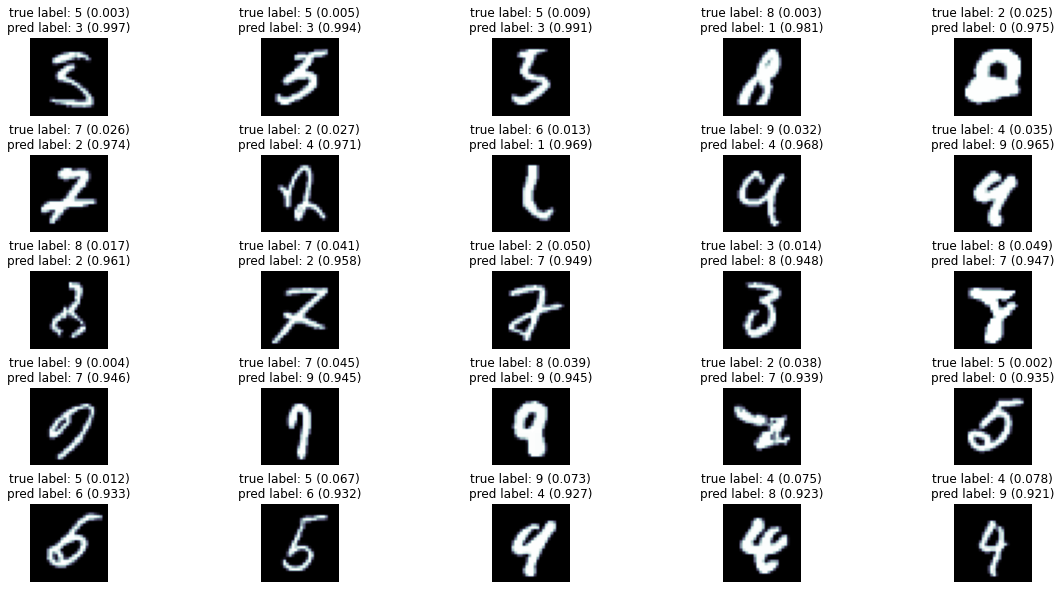

In [30]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [31]:
def get_representation(model, iterator, device):
    preds, intermediates, labels = [], [], []

    model.eval()

    with torch.no_grad():
        for image, label in iterator:
            image = image.to(device)

            pred, h = model(image)

            preds.append(pred.cpu())
            intermediates.append(h.cpu())
            labels.append(label)
    
    
    preds = torch.cat(preds, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return preds, intermediates, labels

In [32]:
preds, intermediates, labels = get_representation(model, test_iterator, device)

In [33]:
from sklearn import decomposition

def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)

    return pca_data

def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

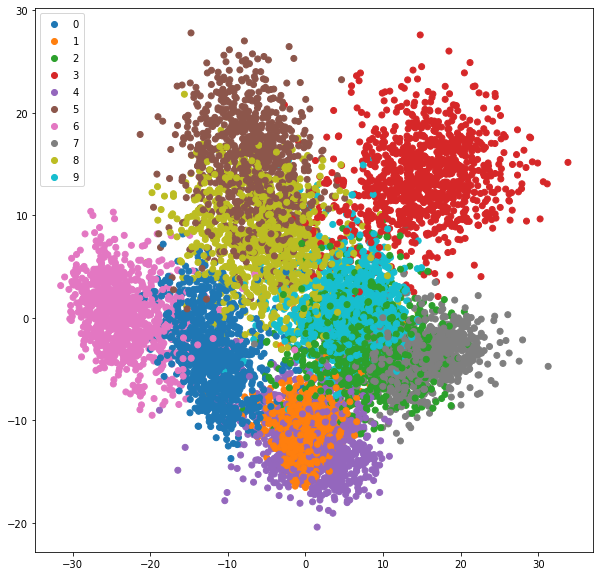

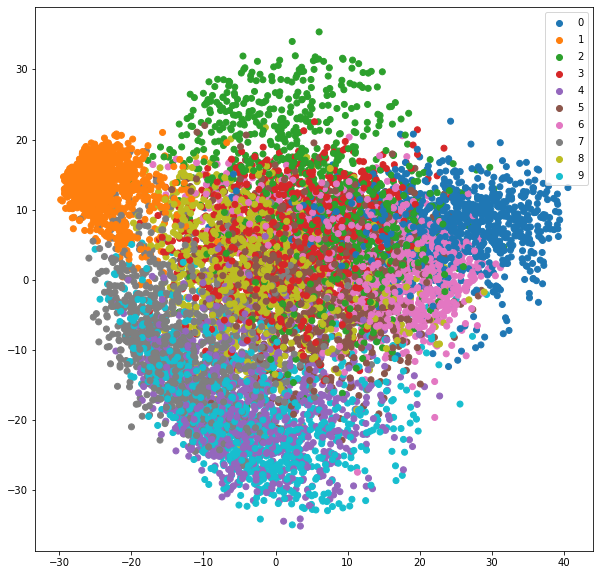

In [34]:
pca_data = get_pca(preds)
plot_representations(pca_data, labels)
pca_data = get_pca(intermediates)
plot_representations(pca_data, labels)